In [1]:
import os, sys, time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mvpa2.suite as mvpa2
import itertools

from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

TR = 2.3

brands = np.array(['abercrombie-fitch','adobe','apple','axe','beats',
          'campina','dell','disney','durex','heineken','kelloggs',
          'microsoft','pampers','redbull'])

cat_names = ['party','work','sex','family']

sns.reset_orig()
plt.rc('font', family='Arial', size=8)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)

In [2]:
brand_equity = np.loadtxt('../survey/post/brand_equity.csv',delimiter=',')
brand_equity[:,-1] = 100 - brand_equity[:,-1]

brand_loyalty = np.mean(brand_equity[:,2:5],axis=1)
brand_quality = np.mean(brand_equity[:,5:7],axis=1)

brand_preference = np.mean(brand_equity[:,2:7],axis=1)
brand_association = np.mean(brand_equity[:,7:12],axis=1)

brand_loyalty_avg = [np.mean(brand_loyalty[brand_equity[:,1]==b]) for b in range(14)]
brand_quality_avg = [np.mean(brand_quality[brand_equity[:,1]==b]) for b in range(14)]

brand_preference_avg = [np.mean(brand_preference[brand_equity[:,1]==b]) for b in range(14)]
brand_association_avg = [np.mean(brand_association[brand_equity[:,1]==b]) for b in range(14)]

In [3]:
method = 'normalized_common'
r = 'picture_thresh2'

file_path = '../output/'+method+'/'+r.replace("picture","brand")

subj_brand_ds = {}
allsubjs = np.array(range(4,42))

for subj in allsubjs:
    subj_brand_ds[subj] = mvpa2.Dataset.from_hdf5(file_path+'/S'+str(subj)+'.h5py')

In [4]:
TR_type = 't012'
tp = 6

subjs = allsubjs[(allsubjs != 8)]

brand_reliability = []

for b in range(14):
    b_r = []
    for subj in subjs:
        brand_ds = subj_brand_ds[subj]

        b_r.append(\
        np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                             (brand_ds.sa.timepoint >= tp+0) & \
                             (brand_ds.sa.timepoint < tp+0+TR)]\
                            .sa[TR_type+'_rsa']),axis=0))
    brand_reliability.append(squareform(pdist(np.array(b_r),metric='correlation')))

neural_reliability = [np.mean(squareform(b)) for b in brand_reliability]
print sp.stats.pearsonr(neural_reliability,brand_association_avg), sp.stats.pearsonr(neural_reliability,brand_preference_avg), sp.stats.pearsonr(neural_reliability,brand_loyalty_avg), sp.stats.pearsonr(neural_reliability,brand_quality_avg)

(-0.62679872487508159, 0.016446804790007274) (-0.32872513520389368, 0.25115238813245999) (-0.32229402482350861, 0.26109663921316678) (-0.30137295552409343, 0.29505339955207777)


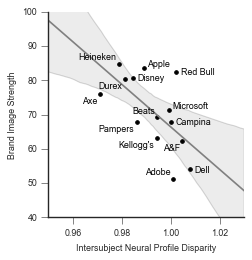

(-0.62679872487508159, 0.016446804790007274)

In [6]:
d = {'neural': neural_reliability,#[np.mean(zz[zz[:,5]==m,4]) for m in range(14)], 
     'behave': brand_association_avg}#[np.mean(zz[zz[:,5]==m,3]) for m in range(14)]}
df = pd.DataFrame(data=d)
sns.reset_orig()
sns.set_style("ticks")
plt.rc('font', family='Arial',size=8)
sns.set_palette([(0.5,0.5,0.5),(0,0,0)],n_colors=1,desat=0.0)
sns.lmplot(x="neural", y="behave", data=df,markers='o',size=3.3,scatter_kws={"s": 0, "color":'k'})

for label, x, y in zip(brands, neural_reliability, brand_association_avg):
    ha = 'right'
    va = 'bottom'
    if label in ['kelloggs','abercrombie-fitch','durex','axe','pampers']:
        offset = (-2,-2)
        va = 'top'
    elif label in ['redbull','dell','campina','disney']:
        offset = (4,0)
        ha = 'left'
        va = 'center'
    elif label in ['xxx']:
        offset = (-2,-2)
        ha = 'right'
        va = 'top'
    elif label in ['durex']:
        offset = (3,-3)
        ha = 'center'
        va = 'top'
    elif label in ['apple','microsoft','pampers']:
        offset = (3,0)
        ha = 'left'
        va = 'bottom'
    #elif label in []:
    #    offset = (-2,0)
    #    va = 'top'
    #elif label in ['disney']:
    #    offset = (0,4)
    #    ha = 'center'
    else:
        offset = (-2,2)
    
    if label == 'abercrombie-fitch':
        brand_name = "A&F"
    elif label == 'kelloggs':
        brand_name = "Kellogg\'s"
    elif label == 'redbull':
        brand_name = "Red Bull"
    else:
        brand_name = label.capitalize()
    plt.annotate(
        brand_name, 
        xy = (x, y), xytext = offset, fontsize=8, color = 'k',
        textcoords = 'offset points', ha = ha, va = va)

plt.scatter(neural_reliability, brand_association_avg, color='k',s=10)

plt.xticks([0.96,0.98,1,1.02],)
plt.xticks([0.96,0.98,1,1.02])
#plt.yticks([3,4,5,6,7])
#plt.yticks([-2,0,2])
plt.ylim([40,100])
#plt.xlim([0.97,1.01])
#plt.ylim([3,7])
plt.ylabel("Brand Image Strength")
plt.xlabel("Intersubject Neural Profile Disparity")

#plt.rc('lines', color= 'black')
plt.savefig('reliability_average_pub.pdf',fmt='pdf')
plt.show()
sp.stats.pearsonr(d['neural'],d['behave'])

In [136]:
null_res = []
tp = 6

for p in range(10000):
    null_neural_reliability = []
    
    for b in range(14):
        b_r = []
        for subj in subjs:
            brand_ds = subj_brand_ds[subj]
            b_r.append(\
            np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[np.random.randint(14)]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa['t012_rsa']),axis=0))
        null_neural_reliability.append(np.mean(pdist(np.array(b_r),metric='correlation')))
    
    null_corr = np.corrcoef([null_neural_reliability,brand_association_avg,brand_preference_avg,brand_loyalty_avg,brand_quality_avg])
    null_res.append(null_corr[0][1:])
    
    if p % 100 == 0:
        print "*",
#np.save('../output/nulldata_analysis_4.npy', np.array(null_res))

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [153]:
print sp.stats.percentileofscore(null_res[:,0],-0.626)*2/100

0.0032


## Supplementary Analysis 9

In [147]:
TR_type = 't012'

tp = 6

subjs = allsubjs[(allsubjs != 8)]

results = []

for thres in [28,28*2,28*3]:
    all_res = []
    for perm in range(1000):
        mask = (np.arange(112) < thres)
        np.random.shuffle(mask)

        brand_reliability = []

        for b in range(14):
            b_r = []
            for subj in subjs:
                brand_ds = subj_brand_ds[subj]

                b_r.append(\
                np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                     (brand_ds.sa.timepoint >= tp+0) & \
                                     (brand_ds.sa.timepoint < tp+0+TR)]\
                                    .sa[TR_type+'_rsa']),axis=0))
            brand_reliability.append(squareform(pdist(np.array(b_r)[:,mask],metric='correlation')))

        neural_reliability = [np.mean(squareform(b)) for b in brand_reliability]
        all_res.append(sp.stats.pearsonr(neural_reliability,brand_association_avg)[0])
        
        if perm % 100 == 0:
            print "*",
            
    results.append(all_res)
    print np.mean(all_res),np.std(all_res)    

* * * * * * * * * * -0.517725534375 0.125331646942
* * * * * * * * * * -0.585291097051 0.0793915801381
* * * * * * * * * * -0.614184694874 0.0446140998109


In [148]:
tp = 6
for part in range(4):
    mask = ((np.arange(112) < part*28) | (np.arange(112) >= (part+1)*28))
    #np.random.shuffle(mask)

    brand_reliability = []

    for b in range(14):
        b_r = []
        for subj in subjs:
            brand_ds = subj_brand_ds[subj]

            b_r.append(\
            np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp+0) & \
                                 (brand_ds.sa.timepoint < tp+0+TR)]\
                                .sa[TR_type+'_rsa']),axis=0))
        brand_reliability.append(squareform(pdist(np.array(b_r)[:,mask],metric='correlation')))

    neural_reliability = [np.mean(squareform(b)) for b in brand_reliability]
    print sp.stats.pearsonr(neural_reliability,brand_association_avg)

(-0.63498485845181263, 0.014694729572576054)
(-0.51139132703292234, 0.061611638330473582)
(-0.36239767937011946, 0.20288530568273797)
(-0.71694640170763346, 0.0039052811262125777)


## Supplementary Analysis 11

In [156]:
TR_type = 't0'
time_series = []
for tp in range(20):
    subjs = allsubjs[(allsubjs != 8)]

    brand_reliability = []

    for b in range(14):
        b_r = []
        for subj in subjs:
            brand_ds = subj_brand_ds[subj]

            b_r.append(\
            np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa[TR_type+'_rsa']),axis=0))
        brand_reliability.append(squareform(pdist(np.array(b_r),metric='correlation')))

    neural_reliability = [np.mean(squareform(b)) for b in brand_reliability]
    time_series.append(sp.stats.pearsonr(neural_reliability,brand_association_avg)[0])
    print sp.stats.pearsonr(neural_reliability,brand_association_avg), sp.stats.pearsonr(neural_reliability,brand_preference_avg)

(-0.0017377691103528416, 0.99529582838945885) (0.34509206630183459, 0.22689537003770732)
(-0.41518526685355911, 0.13987538149369583) (-0.083387741905782839, 0.77686112167430443)
(-0.47443421231406502, 0.086516719412518067) (-0.34025389292970931, 0.2339088518576983)
(-0.45743471535641189, 0.10005477335039188) (-0.11202762231561313, 0.7029863767605431)
(-0.3845051139175073, 0.1746428543654511) (0.026931870301699697, 0.92718264241191173)
(-0.37290533491074579, 0.18912384414515548) (0.11850894475660263, 0.68657652098927191)
(-0.59810468040039488, 0.023864226900654237) (-0.11587850714497296, 0.69322143923960056)
(-0.41148569248015349, 0.14380022546676005) (-0.20462878988123842, 0.48283640122913696)
(-0.39299827726588304, 0.16450886094856113) (-0.32501557969709638, 0.25685995572014292)
(-0.51508103759191959, 0.059445845957763171) (-0.30933884677538598, 0.28183490994543592)
(-0.52271302782732609, 0.055140668940278671) (-0.41032536507191064, 0.14504614046527034)
(-0.46822144175937752, 0.091305

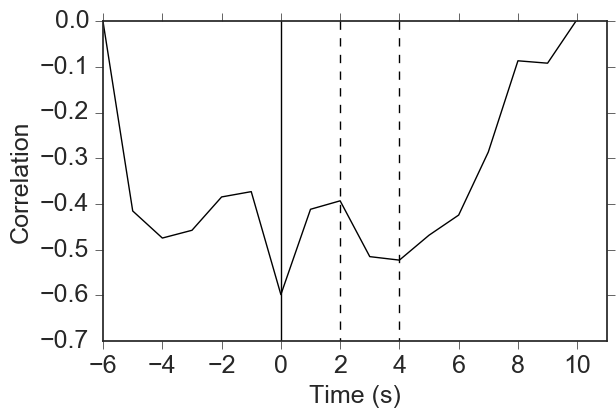

In [157]:
plt.figure(figsize=(6.5,4))
plt.plot(range(-6,12),time_series[0:18],'k')
plt.plot([0,0],[0,-0.7],'k')
plt.plot([2,2],[0,-0.7],'k--')
plt.plot([4,4],[0,-0.7],'k--')
#plt.plot([11,11],[0,-0.7],'k--')
#plt.yticks([0,-0.1,-0.2,-0.3,-0.4])
plt.xlim([-6,11])
plt.ylim([-0.7,0])
plt.xlabel("Time (s)")
plt.ylabel("Correlation")
plt.savefig("robust_h4.pdf",fmt="pdf")
plt.show()